# GHRSST Training Ahmedabad (2023-10-20) - Using GHRSST User Services
**Contact**: Jean-François Piollé, Ifremer, FRANCE (jfpiolle@ifremer.fr)

In this training session we will learn how to use the GHRSST data search services, including:

* the product **catalogue** listing the different datasets provided by the producing agencies in GHRSST format and content
* the **Opensearch** API to  select the files of a given collection matching some space and time criteria

These services were implemented by Ifremer with the support of Europe *Copernicus* framework funding.

<figure>
    <img src=./logo_ghrsst.gif width="150"> 
    <img src=./logo_copernicus.png width="100" align="right">
</figure>

## Requirements

We need to have jupyter lab or jupyter notebook installed on your laptop. We recommend installation with `conda` or `mamba` environment managers.

This notebooks runs with python 3. You need to have the following extra python packages in your jupyter kernel:
* requests
* xarray
* shapely
* matplotlib
* cartopy
* netcdf4

If you have installed jupyter lab/notebook in a conda/mamba env, it is better to create an independent environment for this opensearch training. With mamba or conda, follow these instructions:

```
mamba create -n opensearch python=3.10
mamba activate opensearch
mamba install requests shapely xarray matplotlib cartopy
mamba install ipykernel
python -m ipykernel install --name opensearch
mamba deactivate
```

Then start jupyter. The `opensearch` environment we just created should be in the list of the available kernels. Select this kernel to run this notebook.

## The GHRSST Catalogue

The GHRSST Catalogue is accessible on GHRSST website: GHRSST catalogue at: https://www.ghrsst.org/ghrsst-data-services/ghrsst-catalogue/

We will learn in this step how to select the right dataset for your usage, using the search filters (facets) of the catalogue. 

<figure>
    <img src=./catalog_main_view.png width="300" align="left">
</figure>

## The GHRSST Opensearch service

The GHRSST **Opensearch** service allows users to search for data files from any GHRSST data collection listed in GHRSST catalogue on any spatial or temporal criteria. The returned result include the different download paths available from the different GHRSST Data Assembly Centers (DAC) for each found data file.

Each DAC provides its own Opensearch end-point but the GHRSST central Opensearch service connects them all!

The service can be accessed at: https://opensearch-ghrsst.ifremer.fr. The homepage of the service explains the syntax of the search queries with many examples.

This notebook shows how to query the GHRSST Opensearch service in python, using the json return format (Atom/XML being the alternative format).



### Selecting files for a GHRSST dataset

Here are the main functions needed to build the Opensearch queries and decode the returned results. Examples of usage are provided in the following steps.

In [3]:
import json
import urllib.request
from datetime import datetime
from typing import Tuple


# the service end-point URL
GHRSST_OPENSEARCH_URL = "https://opensearch-ghrsst.ifremer.fr/granules.json"

def _format_opensearch_url(
        dataset_id: str,
        start: datetime,
        end: datetime,
        area= None,
        dac=None,
        protocol=None,
        page=0,
        count=1000,
        trace=False
):
    """creates the opensearch query string from search arguments"""
    
    # build the search query URL
    search_url = GHRSST_OPENSEARCH_URL + \
        '?datasetId={}'.format(dataset_id) + \
        '&startPage={}&count={}'.format(page, count) + \
        '&timeStart={}&timeEnd={}'.format(start.isoformat(), end.isoformat())

    if area is not None:
        search_url += '&geoBox={}'.format(str(tuple(area)).replace(' ','').lstrip('(').strip(')'))
    
    if dac is not None:
        search_url += '&source={}'.format(dac)

    if protocol is not None:
        search_url += '&protocol={}'.format(protocol)
    
    if trace:
        print(search_url)

    return search_url


def format_opensearch_result(entries):
    """format the search result as a list, merge duplicates"""
    dict_entries = {}
    for entry in entries:
        file_id = entry['title'] 

        # for each links, relate to corresponding source
        for link in entry['links']:
            link['source'] = entry['source']
        entry.pop('source')
        
        if not file_id.endswith('.nc'):
            # PODAAC strips the .nc extension from the filename.
            file_id = file_id + '.nc'
        if file_id in dict_entries:
            # merge with existing entry if the same granule was 
            # returned from another DAC
            dict_entries[file_id]['links'].extend(entry['links'])
            # some attributes are not always filled in some DAC responses.
            # we fill them in the merging, whenever it is provided by one of the DACs
            for attr in dict_entries[file_id]:
                if entry[attr] is not None and attr != 'links':
                    dict_entries[file_id][attr] = entry[attr]
        else:
            dict_entries[file_id] = entry

    # sort by filename
    dict_entries = {_: dict_entries[_] for _ in sorted(dict_entries.keys())}
                                                       
    return dict_entries


def search(
        dataset_id: str,
        start: datetime,
        end: datetime = None,
        area: Tuple[float, float, float, float] = None,
        dac: str = None,
        protocol: str = None,
        trace: bool = False
    ):
    """The main search function. Queries data files from a given GHRSST collection.
    
    When the same data files are returned from different DACs, they are merged into a 
    single entry in the list of results, providing all the possible download URLs. 
    
    It is possible to request the results from a specific DAC only, or for a given download
    protocol (FTP, HTTP, ...).
    
    Args:
        dataset_id: the identifier of the collection, as found in GHRSST catalogue.
        start: the start date and time of the search temporal interval, as a python 
            datetime object.
        end: the end date and time of the search temporal interval, as a python 
            datetime object. By default, the current date and time is used.
        area: the boundaries of the search area, as a list [lon min, lat min, lon max, lat max]. 
            By default the whole world is selected.
        dac: the identifier of the DAC to query. By default all DACs are queried. Use this
            argument to limit the search to a specific DAC.
        protocol: the type of download link to be returned for each found data file. By
            default, all links are returned. Use this argument to include in the search results
            only FTP, HTTPS, etc links.
        trace: print some traces of the queries to opensearch service
    """
    results = []

    if end is None:
        end = datetime.now()

    last_page = False
    page = 0
    while not last_page:
        # format the opensearch query
        uri = _format_opensearch_url(
            dataset_id, start, end, area, dac=dac, protocol=protocol, page=page)
        
        # call the service
        response = urllib.request.urlopen(uri)
        status_code = response.getcode()
        if trace:
            print(f'Requesting page {page}: {uri}')
            print("HTTP STATUS CODE = " + str(status_code))
        
        # decode json result
        json_result = json.loads(response.read())
        status, entries = json_result['header'], json_result['entries']
        
        results.extend(entries)
        
        if status['total_results'] < (status['start_index']+1)*status['items_per_page']:
            last_page = True
        
        page += 1

    # merge duplicates (if results coming from more than one dac)    
    return format_opensearch_result(results)




## Examples

### Basic search 

In this example, we will query data files from the OSI SAF Metop-A L2P dataset; We should first the know the GHRSST identifier of this dataset to be used in the search query; it is the identifier provided in the catalogue, in the title of the top right column providing the dataset properties: 

<figure>
    <img src=./catalogue.png> 
</figure>


Here the identifier is ``AVHRR_SST_METOP_B-OSISAF-L2P-v1.0``.

We can then simply use the ``search`` function defined above, providing also the time frame (as *datetime* python objects) and the area, as a tuple *(lon min, lat min, lon max, lat max)*, of interest. In this example we select data over North-East India.

`trace=True` prints the actual URL that corresponds to the query (built by the piece of code provided above). Set `trace=False` to avoid later these logs. For big queries, you will notice that several queries are made to Opensearch as it is a paginated result: when the list of matching files is too large, it is splitted in several pages that must be queried one by one (this iteration is implemented in the provided code above).

In [4]:
# identifier, as provided in GHRSST catalogue
datasetId = "AVHRR_SST_METOP_B-OSISAF-L2P-v1.0"

# area of interest (lon min, lat min, lon max, lat max)
area = (65.0, 17.0, 75.0, 25.0)

# timeframe of interest
start = datetime(2018, 8, 5)
end = datetime(2018, 8, 6)

result = search(datasetId, start=start, end=end, area=area, trace=True)

print(f'Number of files found: {len(result)}')

Requesting page 0: https://opensearch-ghrsst.ifremer.fr/granules.json?datasetId=AVHRR_SST_METOP_B-OSISAF-L2P-v1.0&startPage=0&count=1000&timeStart=2018-08-05T00:00:00&timeEnd=2018-08-06T00:00:00&geoBox=65.0,17.0,75.0,25.0
HTTP STATUS CODE = 200
Number of files found: 16


### Inspecting the returned result

The result of above query is a python dictionary, which keys are the names of the returned files and the values are the properties, including the download links, in the `links` property.

Let's for instance print the first element in this dictionary.

In [8]:
# for nice printing
import pprint
pp = pprint.PrettyPrinter(indent=4)

# pretty print the first element
pp.pprint(list(result.items())[0])

(   '20180805034903-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_034903-v02.0-fv01.0.nc',
    {   'dc_date': '2018-08-05 03:49:03/2018-08-05 03:52:03',
        'geo_box': '73.75182598862224 18.97535738463619 104.6565690437366 '
                   '35.07302076195279',
        'geo_line': None,
        'geo_polygon': '74.40027989254958 29.85838001641221 73.75182598862224 '
                       '24.6596729101404 83.44899072329913 23.22019165426103 '
                       '87.6323223565169 22.38606842468297 91.70843873433972 '
                       '21.45615733394105 100.7232345647136 18.97535738463619 '
                       '102.5921727353695 24.08225253091031 104.6565690437366 '
                       '29.11141375389636 94.94132591266174 31.96847375501645 '
                       '90.42043409929983 32.9524135271757 85.78976480262284 '
                       '33.82693069158194 75.02804985874033 35.07302076195279 '
                       '74.40027989254958 2

We can see there are different links available for the data files, some coming from different GHRSST Data Assembly Centers or DAC (as seen in `source` attribute): these data are indeed served by both `OSISAF` (the original producer) and `PODAAC` (which mirrors these data). In the following we show how to restrict the results to a given DAC and given type of link (protocol).

### More search criteria

It is possible to further limit the search results. In particular:
* asking for the results of a specific GHRSST Data Assemble Center (DAC) using `dac` argument in the `search` function. Possible values include *OSISAF*, *PODAAC*, *EUMETSAT*, ... (check in the central catalogue which DACs are available for a given GHRSST dataset).
* asking for the download linls in a given protocol only, using `protocol` argument. Possible values include: *FTP*, *HTTPS*, ...

In the first example below, we perform the same request but asking only for the results from *OSISAF* DAC; it can be verified that only the links from OSISAF DAC are returned, and that those of PODAAC were dropped out:

In [9]:
# use `DAC` keyword in search function
result = search(datasetId, start=start, end=end, area=area, dac='OSISAF')

# print the first element of result
pp.pprint(list(result.items())[0])

(   '20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-fv01.0.nc',
    {   'dc_date': '2018-08-05 16:43:03/2018-08-05 16:46:03',
        'geo_box': '52.8510088386 12.2808860503 82.1621732853 28.351150483',
        'geo_line': None,
        'geo_polygon': '54.5732747622 17.4459690717 56.193375694 12.2808860503 '
                       '68.9439340278 15.5178208401 72.8979733464 '
                       '16.3531416822 82.1621732853 17.9649078992 '
                       '80.6772508343 28.351150483 70.6291606581 26.9682482658 '
                       '66.31191391108676 26.09269380534525 62.0599909466 '
                       '25.1471051961 52.8510088386 22.5611670566 '
                       '54.5732747622 17.4459690717',
        'geo_where': None,
        'id': 'https://opensearch.ifremer.fr/granules.atom?uid=avhrr_sst_metop_b-osisaf-l2p-v1.0:20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-

Note that searching for a dataset by specifying a DAC that does not serve this dataset will return a `Not Found` 404 error

In [10]:
result = search(datasetId, start=start, end=end, area=area, dac='EUMETSAT')

HTTPError: HTTP Error 404: Not Found

In this second example, we will limit the results to those for which a FTP link is provided, using `protocol` argument. Other links are dropped from the results. 

In [11]:
# use `protocol` keyword in search function
result = search(datasetId, start=start, end=end, area=area, protocol='FTP')

# print the first element of result
pp.pprint(list(result.items())[0])

(   '20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-fv01.0.nc',
    {   'dc_date': '2018-08-05 16:43:03/2018-08-05 16:46:03',
        'geo_box': '52.8510088386 12.2808860503 82.1621732853 28.351150483',
        'geo_line': None,
        'geo_polygon': '54.5732747622 17.4459690717 56.193375694 12.2808860503 '
                       '68.9439340278 15.5178208401 72.8979733464 '
                       '16.3531416822 82.1621732853 17.9649078992 '
                       '80.6772508343 28.351150483 70.6291606581 26.9682482658 '
                       '66.31191391108676 26.09269380534525 62.0599909466 '
                       '25.1471051961 52.8510088386 22.5611670566 '
                       '54.5732747622 17.4459690717',
        'geo_where': None,
        'id': 'https://opensearch.ifremer.fr/granules.atom?uid=avhrr_sst_metop_b-osisaf-l2p-v1.0:20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-

Same as above but selecting only HTTP(S) links from OSISAF DAC now: 

In [12]:
# use `protocol` keyword in search function
result = search(datasetId, start=start, end=end, area=area, dac='OSISAF', protocol='HTTPS')

# print the first element of result
pp.pprint(list(result.items())[0])

(   '20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-fv01.0.nc',
    {   'dc_date': '2018-08-05 16:43:03/2018-08-05 16:46:03',
        'geo_box': '52.8510088386 12.2808860503 82.1621732853 28.351150483',
        'geo_line': None,
        'geo_polygon': '54.5732747622 17.4459690717 56.193375694 12.2808860503 '
                       '68.9439340278 15.5178208401 72.8979733464 '
                       '16.3531416822 82.1621732853 17.9649078992 '
                       '80.6772508343 28.351150483 70.6291606581 26.9682482658 '
                       '66.31191391108676 26.09269380534525 62.0599909466 '
                       '25.1471051961 52.8510088386 22.5611670566 '
                       '54.5732747622 17.4459690717',
        'geo_where': None,
        'id': 'https://opensearch.ifremer.fr/granules.atom?uid=avhrr_sst_metop_b-osisaf-l2p-v1.0:20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-

### Displaying the spatial coverage of the files found in the search area

Let's first display the location of all found granules with ``cartopy`` using the ``geometry`` property provided in each returned item.

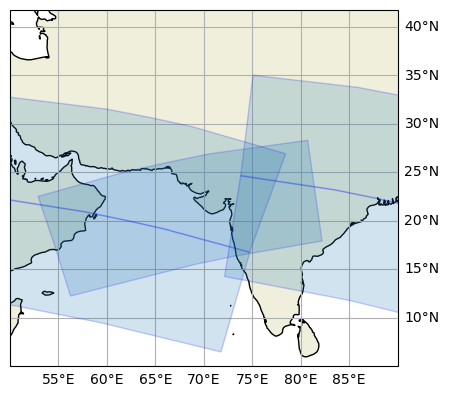

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon

fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
land_50m = cfeature.NaturalEarthFeature(
    'physical', 'land', '50m', edgecolor='face',
    facecolor=cfeature.COLORS['land'])
ax.add_feature(land_50m)
ax.coastlines('50m')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.left_labels = False
ax.set_extent([50, 90, 5, 40])

for item in result.values():
    # build a shapely polygon from the coordinates provided in 'geo_polygon'
    # Warning: 'geo_polygon' is not always defined; you can use `geo_box' instead
    # (a square bounding box)
    if item['geo_polygon'] is None:
        continue
    coords = [float(_) for _ in item['geo_polygon'].split()]
    coords = [(coords[i*2], coords[i*2+1]) for i in range(len(coords)//2)]
    geom = Polygon(coords)
    ax.add_geometries(shape(geom), crs = ccrs.PlateCarree(),
                  edgecolor='blue', zorder = 5, alpha=0.2) 


### Downloading a file

We can use the returned results to actually download the data files of interest, using the `link` information. Let's for instance select the first granule in the returned list: different download links are available, some on FTP server(s), some on HTTP server(s). The same file may be available from different GHRSST Data Assembly Centers. 

Here we will download the granule from a provided HTTP link, using `requests` python package.

Note that on OSISAF server, the access requires a login/password provided here:

In [14]:
# we get the file link in `links` attribute
pp.pprint(list(result.items())[0])

(   '20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-fv01.0.nc',
    {   'dc_date': '2018-08-05 16:43:03/2018-08-05 16:46:03',
        'geo_box': '52.8510088386 12.2808860503 82.1621732853 28.351150483',
        'geo_line': None,
        'geo_polygon': '54.5732747622 17.4459690717 56.193375694 12.2808860503 '
                       '68.9439340278 15.5178208401 72.8979733464 '
                       '16.3531416822 82.1621732853 17.9649078992 '
                       '80.6772508343 28.351150483 70.6291606581 26.9682482658 '
                       '66.31191391108676 26.09269380534525 62.0599909466 '
                       '25.1471051961 52.8510088386 22.5611670566 '
                       '54.5732747622 17.4459690717',
        'geo_where': None,
        'id': 'https://opensearch.ifremer.fr/granules.atom?uid=avhrr_sst_metop_b-osisaf-l2p-v1.0:20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-

In [15]:
import requests

resp = requests.get(
    'https://osi-saf.ifremer.fr/sst/l2p/global/avhrr_metop_b/2018/217/20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-fv01.0.nc', 
    auth=('c1f2a8', 'teleobjectifs-retomberont-simplifieras'))
open('20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-fv01.0.nc', 'wb').write(resp.content)

3755529

### Plotting the content

We will now open and display the downloaded NetCDF file. The file is opened with `xarray` and we display its content with `matplotlib` and `cartopy`.

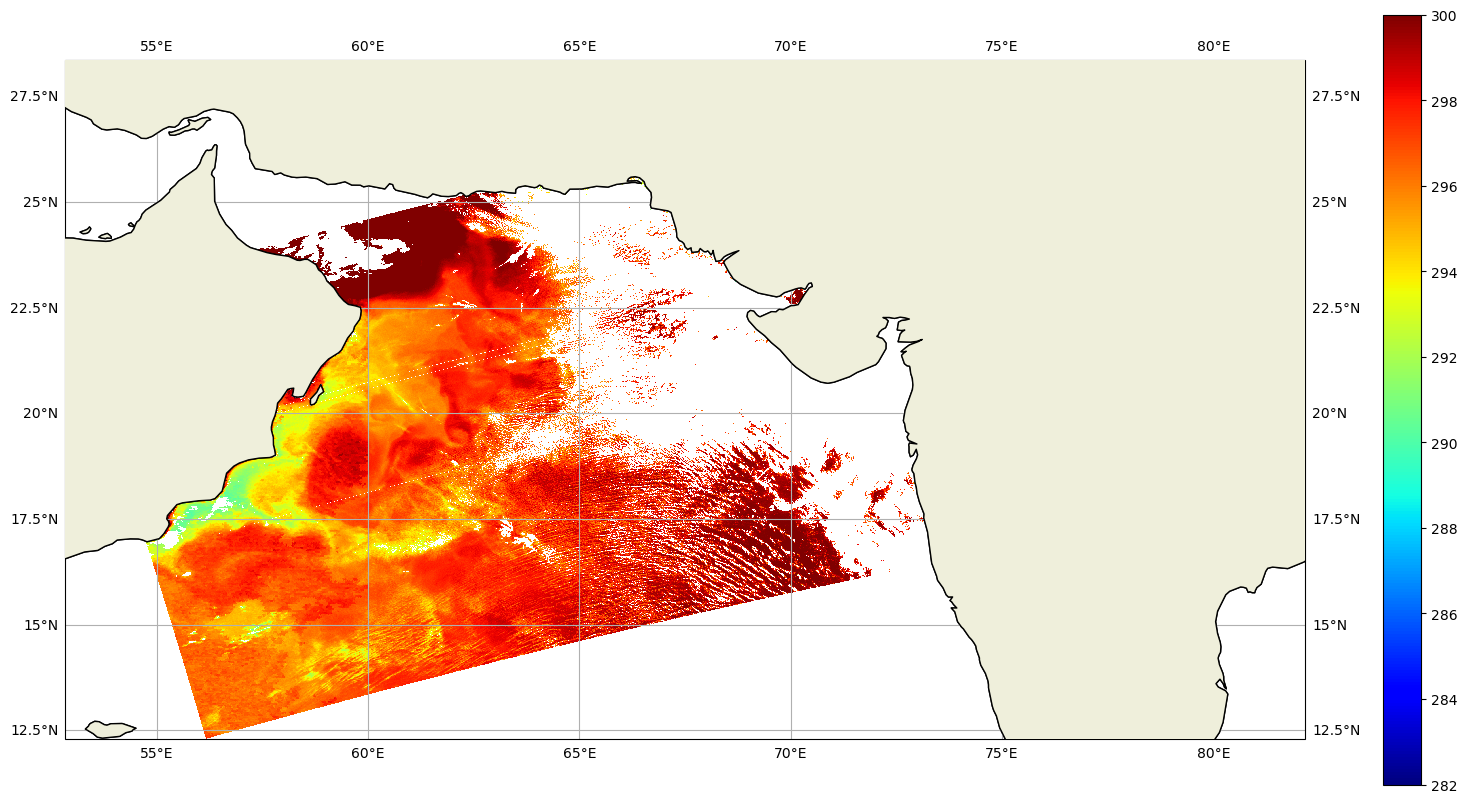

In [16]:
import xarray as xr
import cartopy as cart

# routine to plot SST for a given granule
def plot_sst(dst, sst):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for d in dst:
        plt.pcolormesh(dst.lon, dst.lat, sst, 
                       transform=ccrs.PlateCarree(), cmap='jet',
                       vmin=282, vmax=300)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    #ax.set_extent([16, 19,-32, -29.5])
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    plt.colorbar()
    plt.show()

# open the file and remove the useless `time` dimension
dst = xr.open_dataset(
    '20180805164303-OSISAF-L2P_GHRSST-SSTsubskin-AVHRR_SST_METOP_B-sstmgr_metop01_20180805_164303-v02.0-fv01.0.nc'
).squeeze()

# plot the content of `sea_surface_temperature` variable
plot_sst(dst, dst.sea_surface_temperature)


The SST plotted above is the raw SST (calculated over each pixel where it was possible). In fact many of these areas are cloud covered and the displayed value does not correspond to sea surface temperature. To remove the areas identified as cloudy by the cloud detection processing step, use the `quality_level` information : any quality level lower than 3 should be considered as a cloudy pixel.

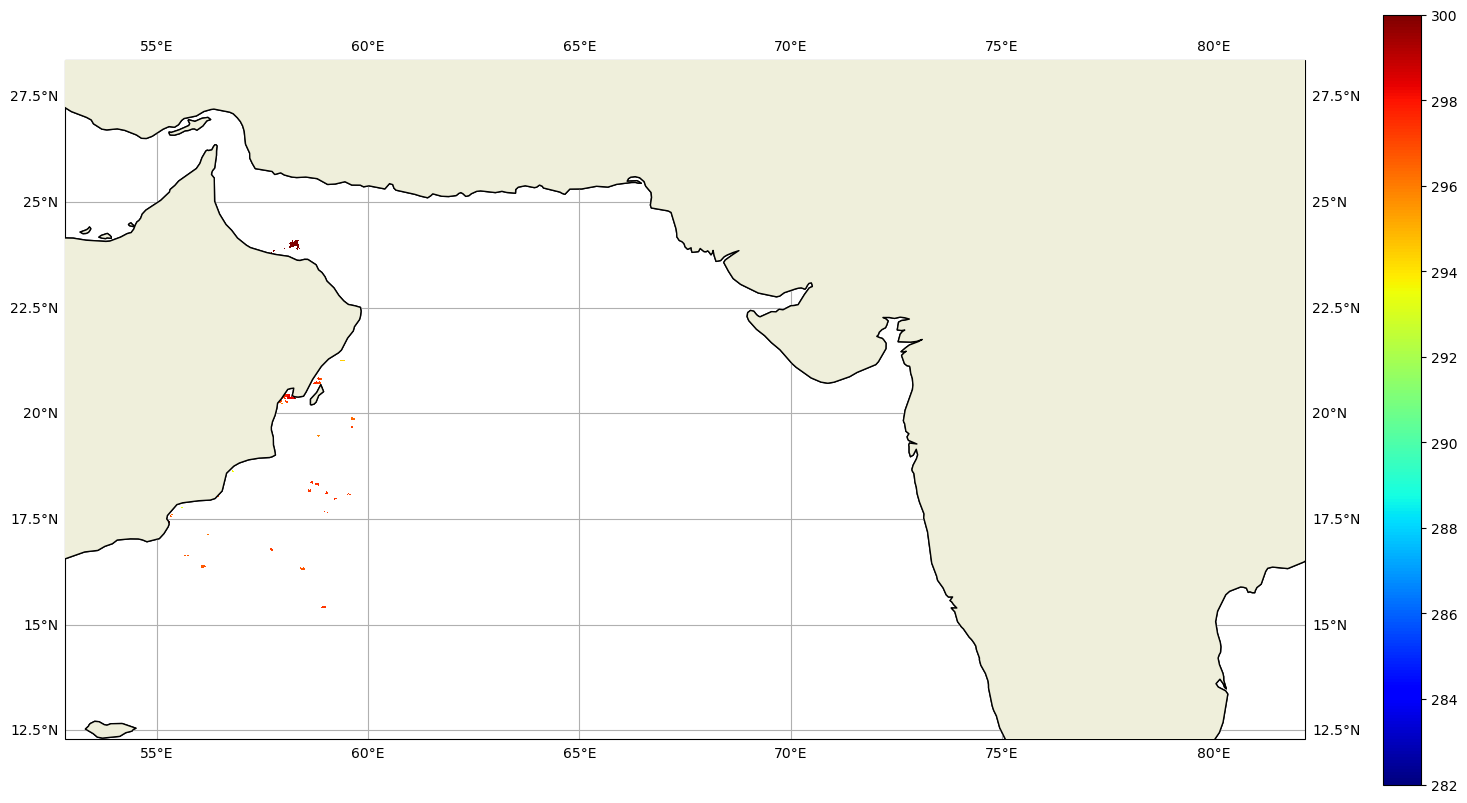

In [18]:
# plot the content of `sea_surface_temperature` variable where quality_level is greater or equal to 3
plot_sst(dst, dst.sea_surface_temperature.where(dst.quality_level>=3))

We see that in fact there were very little clear-sky pixels on this image!

EXERCISE : loop over the other results and try to find a better image!

## Other examples

You can now repeat the previous operations with the dataset of your choice. Here is another example with EUMETSAT SLSTR onboard Sentinel-3 L2P product (Note than EUMETSAT data stores only serves the last month of NRT L2P products, an empty result will be returned beyond this delay and you will have to query other products - like NTC (Non Time Critial) - instead):

In [19]:
# identifier, as provided in GHRSST catalogue
datasetId = "SLSTRA-MAR-L2P-NTC-v3.0"

# timeframe of interest
start = datetime(2022, 9, 1)
end = datetime(2022, 9, 9)

result = search(datasetId, start=start, end=end, area=area)
len(result)


16